In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import keras
import tensorflow as tf

In [ ]:
from sklearn.datasets import load_files

In [ ]:
# The dataset can be downloaded with the code below.
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

The dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips



In [ ]:
data = load_files(base_dir)

In [ ]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

In [ ]:
# How the arrays look like?
print('Data files - ',X)
print()
print('Target labels - ',y) 

Data files -  ['/root/.keras/datasets/flower_photos/dandelion/149782934_21adaf4a21.jpg'
 '/root/.keras/datasets/flower_photos/daisy/153210866_03cc9f2f36.jpg'
 '/root/.keras/datasets/flower_photos/roses/15821959372_518b9dcf57_n.jpg'
 ...
 '/root/.keras/datasets/flower_photos/roses/15951588433_c0713cbfc6_m.jpg'
 '/root/.keras/datasets/flower_photos/sunflowers/4933229479_c1708bd503.jpg'
 '/root/.keras/datasets/flower_photos/sunflowers/6606743797_c90c669757.jpg']

Target labels -  [1 0 2 ... 2 3 3]


Target labels -  [1 0 2 ... 2 3 3], 

numbers are corresponding to class label. We need to change them to a vector of 5 elements.

In [ ]:
# Remove .pyc or .py files

pyc_files = (np.where(file==X) for file in X if file.endswith((',pyc','.py')) )
for pos in pyc_files:
  X = np.delete(X,pos)
  y = np.delete(y,pos)

In [ ]:
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0]) 

Number of training files :  3670
Number of training targets :  3670


In [ ]:
# We have only the file names in X. Time to load the images from filename and save it to X.

from keras.preprocessing.image import img_to_array,load_img

def convert_img_to_arr(file_path_list):
    arr = []
    for file_path in file_path_list:
        img = load_img(file_path,target_size=(224,224))
        img = img_to_array(img)
        arr.append(img)
    return arr

X = np.array(convert_img_to_arr(X))
print(X.shape)
print()
print('1st training item:',X[0])

(3670, 224, 224, 3)

1st training item: [[[ 68. 113.  58.]
  [ 67. 110.  56.]
  [ 72. 111.  58.]
  ...
  [ 52.  83.  41.]
  [ 56.  81.  39.]
  [ 50.  83.  40.]]

 [[ 70. 113.  59.]
  [ 72. 112.  59.]
  [ 73. 112.  59.]
  ...
  [ 54.  81.  40.]
  [ 56.  82.  43.]
  [ 53.  84.  43.]]

 [[ 69. 112.  58.]
  [ 70. 110.  57.]
  [ 70. 110.  57.]
  ...
  [ 52.  83.  41.]
  [ 50.  83.  38.]
  [ 48.  84.  38.]]

 ...

 [[ 74.  91.  59.]
  [ 70.  94.  60.]
  [ 75.  92.  60.]
  ...
  [ 96.  93.  76.]
  [100.  93.  77.]
  [ 98.  92.  80.]]

 [[ 75.  92.  58.]
  [ 73.  94.  61.]
  [ 76.  93.  61.]
  ...
  [ 96.  93.  76.]
  [ 98.  95.  78.]
  [ 97.  93.  81.]]

 [[ 75.  92.  58.]
  [ 73.  97.  61.]
  [ 78.  95.  63.]
  ...
  [ 96.  93.  74.]
  [ 99.  94.  75.]
  [ 96.  93.  76.]]]


(3670, 224, 224, 3)
3670: number of training items

(224,224) : target size

3: RGB channels

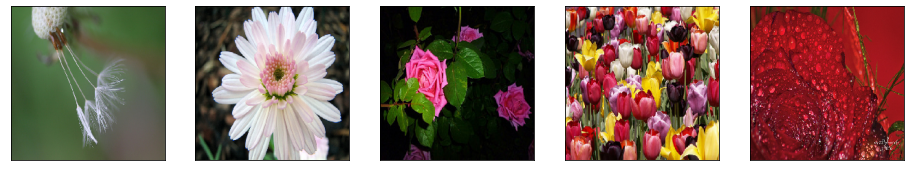

In [ ]:
# #Let's look at first 5 training data.

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,9))
for i in range(5):
  ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
  ax.imshow((X[i].astype(np.uint8)))

In [ ]:
# re-scale so that all values in X lie within 0 to 1

X = X.astype('float32')/255

In [ ]:
# Let's confirm the number of classes

no_of_classes = len(np.unique(y))
no_of_classes

5

In [ ]:
from keras.utils import np_utils

y=np.array(np_utils.to_categorical(y,no_of_classes))
y[0] #Here only one element has value 1(corresponding to its label) and others are 0.

array([0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape[0],X_test.shape[0])
print(y_train.shape[0],y_test.shape[0])

2936 734
2936 734


In [ ]:
y_train.shape[1]

5

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_test,y_test,test_size=0.5)
print(X_train.shape[0],X_valid.shape[0])
print(y_train.shape[0],y_valid.shape[0])

367 367
367 367


**Fine-tuning**

In [ ]:
from keras.models import Model
from keras import optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D,Dense,Flatten,Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [ ]:
# load the VGG16 model without the final layers(include_top=False)
base_model = applications.vgg16.VGG16(weights='imagenet',include_top=False)
print('Model is loaded')

# Let's freeze the first 15 layers
# we are freezing till the last Conv layer.

for layer in base_model.layers[:15]:
    layer.trainable = False

base_model.summary()

Model is loaded
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, Non

In [ ]:
# In the summary above of our base model, trainable params is 7,079,424

# Now, let's create a top_model to put on top of the base model(we are not freezing any layers of this model)

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(no_of_classes,activation='softmax'))
top_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# In the summary above of our base model, trainable params is 2,565

# Let's build the final model where we add the top_model on top of base_model.

model = Sequential()
model.add(base_model)
model.add(top_model)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4,momentum=0.9),
              metrics=['accuracy'])

# When we check the summary below, and trainable params for model is 7,081,989 = 7,079,424 + 2,565

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 sequential_3 (Sequential)   (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Train the model
from keras.preprocessing.image import ImageDataGenerator

epochs = 10
batch_size=32
best_model_finetuned_path = 'best_finetuned_model.hdf5'

train_datagen = ImageDataGenerator( shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
                  X_train,y_train,
                  batch_size=batch_size)

validation_generator = test_datagen.flow(
                      X_valid,y_valid,
                      batch_size=batch_size)

checkpointer = ModelCheckpoint(best_model_finetuned_path,save_best_only = True,verbose = 1)

history = model.fit_generator(
          train_generator,
          steps_per_epoch = len(X_train)//batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=len(X_valid) // batch_size,
          callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 1.9106 - accuracy: 0.1761 
Epoch 1: val_loss improved from inf to 1.91130, saving model to best_finetuned_model.hdf5
11/11 [==============================] - 393s 37s/step - loss: 1.9106 - accuracy: 0.1761 - val_loss: 1.9113 - val_accuracy: 0.1250
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.7368 - accuracy: 0.1881 
Epoch 2: val_loss improved from 1.91130 to 1.72378, saving model to best_finetuned_model.hdf5
11/11 [==============================] - 397s 38s/step - loss: 1.7368 - accuracy: 0.1881 - val_loss: 1.7238 - val_accuracy: 0.1903
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 1.5920 - accuracy: 0.2866 
Epoch 3: val_loss improved from 1.72378 to 1.61868, saving model to best_finetuned_model.hdf5
11/11 [==============================] - 398s 39s/step - loss: 1.5920 - accuracy: 0.2866 - val_loss: 1.6187 - val_accuracy: 0.2614
Epoch 4/10
11/11 [==========================

In [ ]:
model.load_weights(best_model_finetuned_path)

(eval_loss, eval_accuracy) = model.evaluate(X_test,y_test,batch_size=batch_size,verbose=1)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss)) 

23/23 [==============================] - 448s 20s/step - loss: 1.3613 - accuracy: 0.4986
Accuracy: 49.86%
Loss: 1.361318826675415


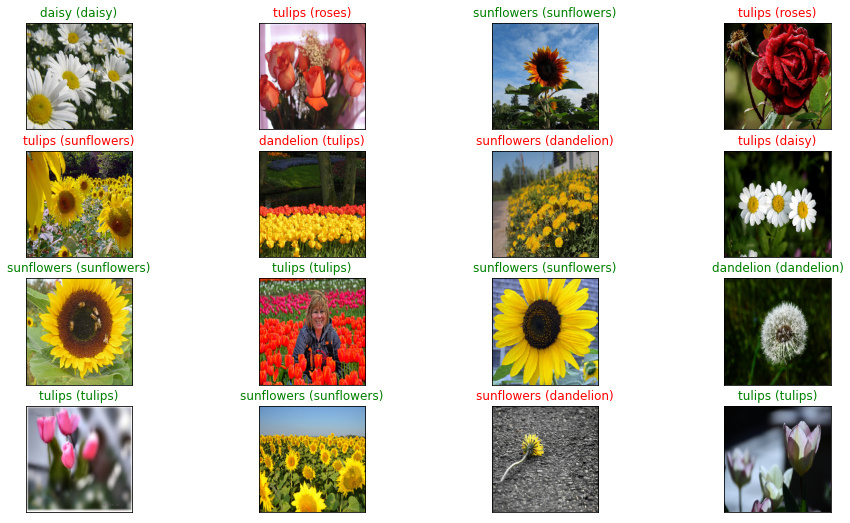

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
   fig = plt.figure(figsize=(16,9))
   for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
visualize_pred(model.predict(X_test))

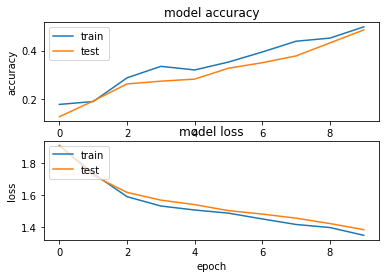

In [ ]:
# Let's visualize the loss and accuracy wrt epochs
def plot(history):
    plt.figure(1)  

    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

    # summarize history for loss  
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()
plot(history)

**Bottleneck features**



In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
import math

In [ ]:
epochs = 10
batch_size=32

model = applications.vgg16.VGG16(weights='imagenet',include_top=False)

datagen = ImageDataGenerator()

generator = datagen.flow(
                        X_train,
                        batch_size=batch_size,
                        shuffle=False)

train_data = model.predict_generator(
             generator, int(math.ceil(len(X_train)/batch_size)))

print(train_data.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


(367, 7, 7, 512)


In [ ]:
generator = datagen.flow(
                        X_valid,
                        batch_size=batch_size,
                        shuffle=False)

validation_data = model.predict_generator(
                  generator, int(math.ceil(len(X_valid)/batch_size)))

validation_data.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


(367, 7, 7, 512)

In [ ]:
generator = datagen.flow(
                        X_test,
                        batch_size=batch_size,
                        shuffle=False)

test_data = model.predict_generator(
                  generator, int(math.ceil(len(X_test)/batch_size)))

test_data.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


(734, 7, 7, 512)

In [ ]:
from keras.layers import GlobalAveragePooling2D,Dense,Flatten,Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

best_model_bottleneck_path = 'best_bottleneck_model.hdf5'

model = Sequential()  
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(no_of_classes, activation='softmax'))  

model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', 
              metrics=['accuracy'])  

checkpointer = ModelCheckpoint(best_model_bottleneck_path,save_best_only = True,verbose = 1)

history = model.fit(train_data, y_train,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, y_valid),
          callbacks =[checkpointer])  

Epoch 1/10
 1/12 [=>............................] - ETA: 4s - loss: 1.5705 - accuracy: 0.2812
Epoch 1: val_loss improved from inf to 1.54518, saving model to best_bottleneck_model.hdf5
12/12 [==============================] - 1s 26ms/step - loss: 1.5962 - accuracy: 0.2234 - val_loss: 1.5452 - val_accuracy: 0.2262
Epoch 2/10
 1/12 [=>............................] - ETA: 0s - loss: 1.5183 - accuracy: 0.2188
Epoch 2: val_loss improved from 1.54518 to 1.47105, saving model to best_bottleneck_model.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1.4923 - accuracy: 0.3351 - val_loss: 1.4710 - val_accuracy: 0.3134
Epoch 3/10
 1/12 [=>............................] - ETA: 0s - loss: 1.4579 - accuracy: 0.3750
Epoch 3: val_loss improved from 1.47105 to 1.43651, saving model to best_bottleneck_model.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1.4394 - accuracy: 0.4114 - val_loss: 1.4365 - val_accuracy: 0.3896
Epoch 4/10
 1/12 [=>............................

In [ ]:
model.load_weights(best_model_bottleneck_path)  
   
(test_loss, test_accuracy) = model.evaluate(  
                            test_data, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(test_accuracy * 100))  
print("Loss: {}".format(test_loss)) 

23/23 [==============================] - 0s 3ms/step - loss: 1.1731 - accuracy: 0.6444
Accuracy: 64.44%
Loss: 1.1731247901916504


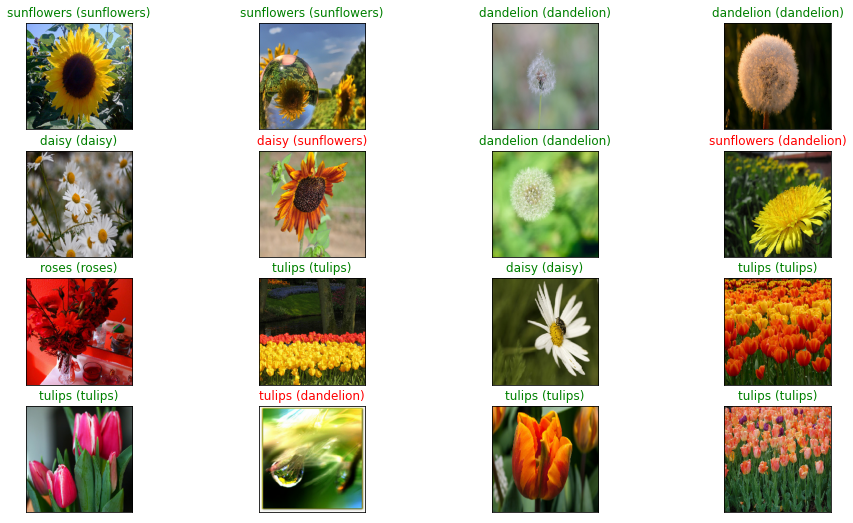

In [ ]:
# Let's visualize some random test prediction.
visualize_pred(model.predict(test_data))

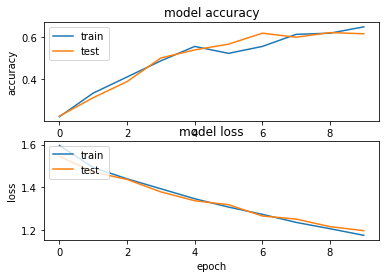

In [ ]:
plot(history)

**Fine-tuning with bottleneck features**

In [ ]:
from keras.models import Model
from keras import optimizers

base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False)

best_model_finetuned_bottleneck = 'best_bottleneck_finetuned_model.hdf5'

for layer in base_model.layers[:15]:
    layer.trainable = False

top_model = Sequential()  
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(no_of_classes, activation='softmax')) 

# loading the weights of bottle neck features model
top_model.load_weights(best_model_bottleneck_path)

model = Sequential()
model.add(base_model)
model.add(top_model)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 sequential_8 (Sequential)   (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
train_datagen = ImageDataGenerator(
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
                  X_train,y_train,
                  batch_size=batch_size)

validation_generator = test_datagen.flow(
                        X_valid,y_valid,
                        batch_size=batch_size)

checkpointer = ModelCheckpoint(best_model_finetuned_bottleneck,save_best_only = True,verbose = 1)

# fine-tune the model

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // batch_size,
    callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 1.1766 - accuracy: 0.6537 
Epoch 1: val_loss improved from inf to 1.17057, saving model to best_bottleneck_finetuned_model.hdf5
11/11 [==============================] - 395s 37s/step - loss: 1.1766 - accuracy: 0.6537 - val_loss: 1.1706 - val_accuracy: 0.6222
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.6567 
Epoch 2: val_loss improved from 1.17057 to 1.13149, saving model to best_bottleneck_finetuned_model.hdf5
11/11 [==============================] - 393s 38s/step - loss: 1.1344 - accuracy: 0.6567 - val_loss: 1.1315 - val_accuracy: 0.6222
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 1.0913 - accuracy: 0.6657 
Epoch 3: val_loss improved from 1.13149 to 1.06042, saving model to best_bottleneck_finetuned_model.hdf5
11/11 [==============================] - 387s 37s/step - loss: 1.0913 - accuracy: 0.6657 - val_loss: 1.0604 - val_accuracy: 0.6477
Epoch 4/10


In [ ]:
model.load_weights(best_model_finetuned_bottleneck)  
   
(test_loss, test_accuracy) = model.evaluate(  
                                            X_test, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(test_accuracy * 100))  
print("Loss: {}".format(test_loss)) 

23/23 [==============================] - 368s 16s/step - loss: 0.7605 - accuracy: 0.7439
Accuracy: 74.39%
Loss: 0.760493814945221


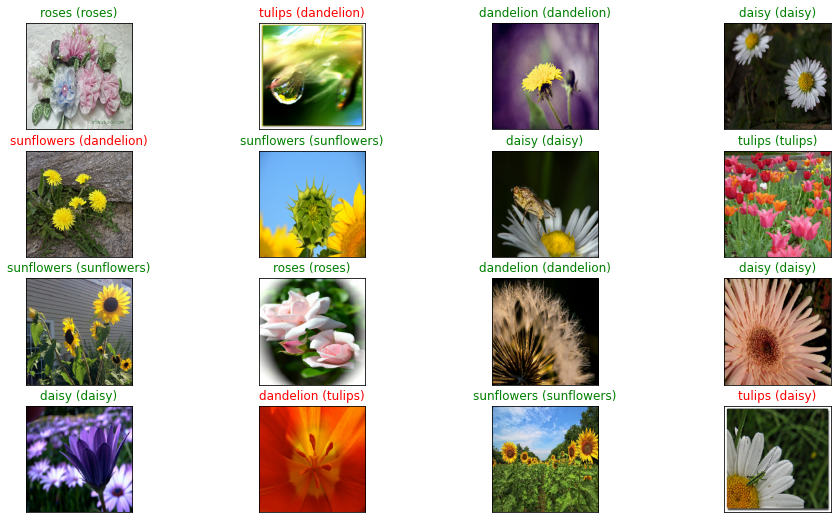

In [ ]:
# Let's visualize some random test prediction.
visualize_pred(model.predict(X_test))

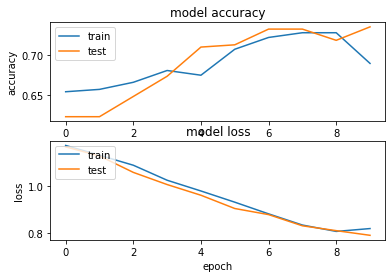

In [ ]:
# Let's visualize the loss and accuracy wrt epochs
plot(history)